Realizar estudios de aprendizaje supervisado utilizando arboles de decisión, tanto para clasificación como para regresión. Para ello en esta tarea se usarán 4 datasets (los tres de la práctica anterior y uno que introduce series temporales).

**Ejercicio 3.** https://www.kaggle.com/datasets/camnugent/california-housing-prices. Predicción de precios de las casas de California. El dataset contiene una serie de datos de casas, como por ejemplo ubicación (latitud y longitud), número de habitaciones dentro de un bloque, número de personas que residen en el bloque, número de hogares, etc. y el valor medio de la vivienda dentro del bloque. El objetivo es, dada una serie de parámetros, predecir el precio que debe tener la casa.

**_Importación de librerías necesarias_**

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from typing import Tuple
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO
import joblib
import matplotlib.pyplot as plt

**_Preproceso_**

*Importación de los datos del dataset*

In [21]:
drive.mount("/content/drive")

df_housing = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/housing.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Mostrar las primera y últimas filas del data frame importado*

In [22]:
df_housing
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no se jupiter se haría de la siguiente forma:
# df_housing.head()
# df_housing.tail()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0
...,...,...,...,...
484,6.593,9.67,21.0,470400.0
485,6.120,9.08,21.0,432600.0
486,6.976,5.64,21.0,501900.0
487,6.794,6.48,21.0,462000.0


*Mostar parámetros estadísticos de los datos (media, desviación típica, quartiles, etc.).*

In [23]:
df_housing.describe() # Muestro los parámetros estadísticos de los datos antes de ser tratados

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


Tratamos los datos para comprobar si existen outliers.

In [24]:
def detectarLimitesOutlier(df: int, k: int = 3) -> tuple:
  Q1 = np.quantile(df, 0.25) # Calculo el quantil 1
  Q3 = np.quantile(df, 0.75) # Calculo el quantil 3
  IQR = Q3 - Q1
  xL = Q1 - k * IQR # Límite inferior
  xU = Q3 + k * IQR # Límite Superior
  return (xL, xU)

def eliminarOutlier(df: pd.DataFrame, listaAtributos: tuple, k = 3) -> pd.DataFrame:
  for atributo in listaAtributos:
    xL, xU = detectarLimitesOutlier(df[atributo], k)
    longitud = len(df[atributo]) - 1
    for x in range(longitud, 0, -1):
      if df[atributo][x] < xL or df[atributo][x] > xU:
        # print(f"La media[{x}] de episodios = {df[atributo][x]} es influyente.")
        df.drop(x, axis=0, inplace=True)

  return df


*Mostrar un mapa de calor que indique la correlación entre variables*

<Axes: >

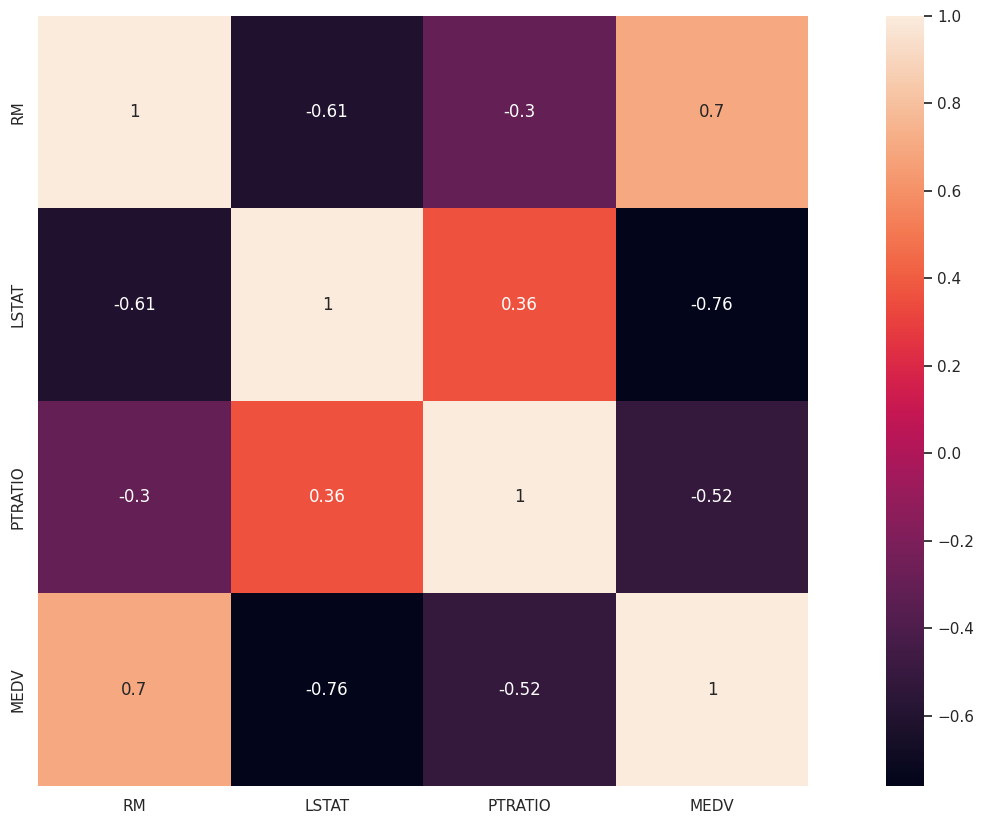

In [25]:
sns.set(rc={"figure.figsize": (20, 10)}) # Esta es una forma de redimensionar el tamaño de la parcela
# plt.figure(figsize=(15, 8)) # Otra forma para redimensionar el tamaño de la parcela
sns.heatmap(df_housing.corr(), square = True, annot = True)

_Seleccionar las características a tener en cuenta en el estudio_

En este ejercicio se van a elegir todas las características por la falta de estas (3 características) y por el valor que tienen estas en el mapa de calor  con la característica objetivo.

*Separar datos entre datos de entrada y etiquetas (resultados)*

In [26]:
x_df_housing = df_housing.drop("MEDV", axis=1)
y_df_housing = df_housing['MEDV']

*Separar datos entre entrenamiento y prueba (usando un 80% para entrenamiento y 20% test)*

In [27]:
x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_housing, y_df_housing, random_state=1, test_size=0.2)

**_Entrenamiento y predicción_**

_Elegir, instanciar (eligiendo unos valores concretos, por ejemplo profundidad del árbol 3) y entrenar el modelo_


In [28]:
modelo = DecisionTreeRegressor(max_depth=3)
modelo.fit(x_entrenamiento, y_entrenamiento)

DecisionTreeRegressor(max_depth=3)

*Realizar una predicción con los datos de prueba*

In [29]:
y_prediccion = modelo.predict(x_test)

_Mostrar el árbol de decisión resultante_

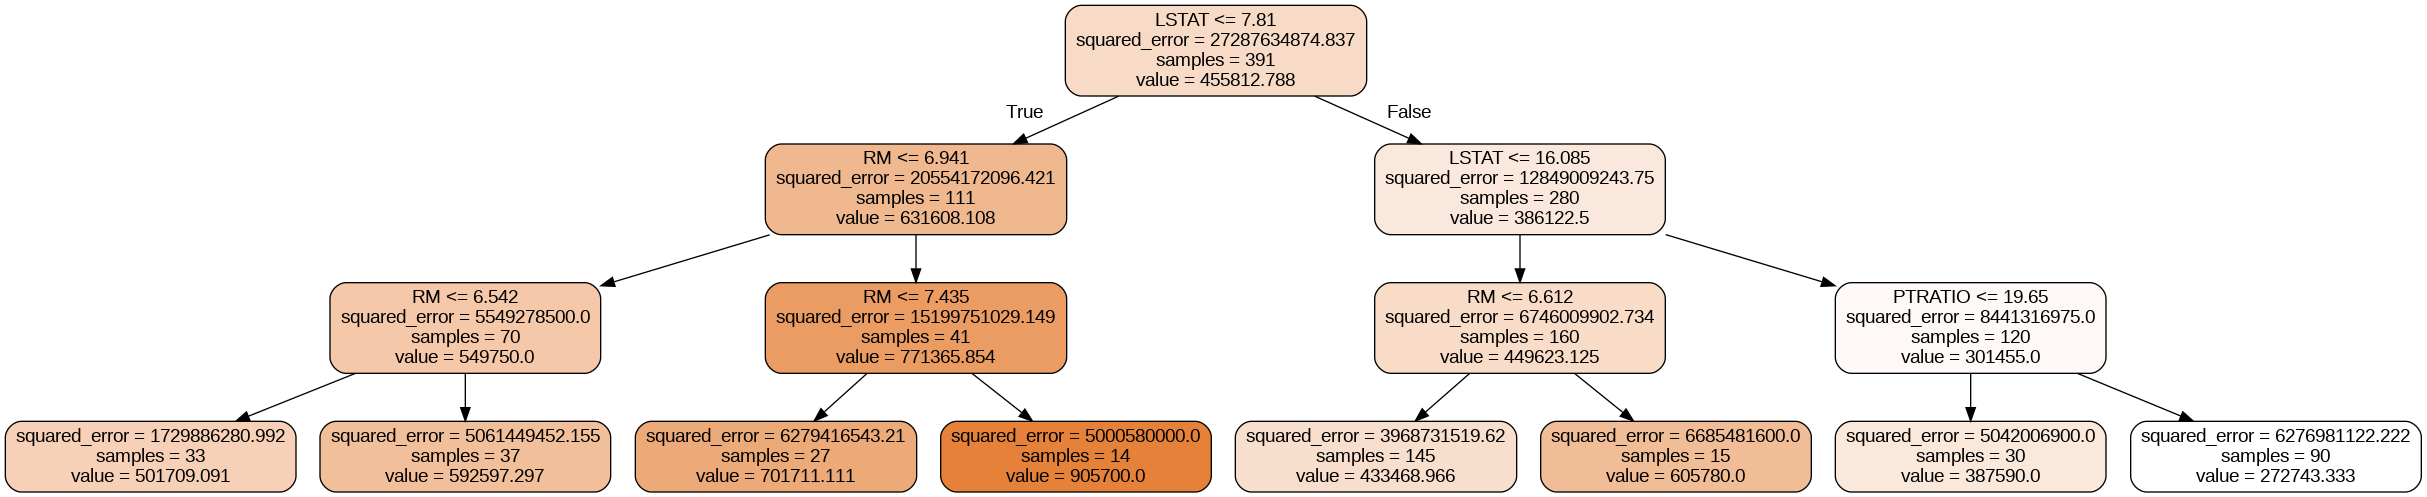

In [30]:
dot_data = StringIO()

tree.export_graphviz(modelo, out_file=dot_data, feature_names=x_entrenamiento.columns, rounded=True, filled=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

_Mostrar la importancia de cada atributo en el arbol resultante_

In [31]:
caracteristicas = ["registered_day", "casual_day", "atemp_day", "temp_day", "yr_day", "instant_day", "atemp_hour", "temp_hour", "yr_hour", "instant_hour"]
for caracteristica, importancia in zip(caracteristicas, modelo.feature_importances_):
  print(f"{caracteristica}: {importancia:.3f}")

registered_day: 0.250
casual_day: 0.716
atemp_day: 0.034


_Intenta guardar el modelo de predicción ya entrenado usando dump (https://scikit-learn.org/stable/modules/model_persistence.html)_

In [32]:
# Guardo el modelo. Se guarda el fichero en colab en el directorio /content.
joblib.dump(modelo, "df_housing_modelo_entrenado.joblib")

['df_housing_modelo_entrenado.joblib']

**_Evaluación_**

*Mostrar el error cuadrático medio (mean_squared_error)*

In [33]:
# Calcula el promedio de los errores al cuadrado
print("El error cuadrático medio:", mean_squared_error(y_test, y_prediccion))

El error cuadrático medio: 6766082605.507382


*Mostrar el error absoluto medio (mean_absolute_error)*

In [34]:
# Calcula el promedio de los errores absolutos entre las predicciones y los valores reales. Este es más fácil de interpretar.
# En este caso se confunde por 58691 €/$
print("El error absoluto medio:", mean_absolute_error(y_test, y_prediccion))

El error absoluto medio: 58691.457498698874


*Representar gráficamente los valores predichos con los valores reales*

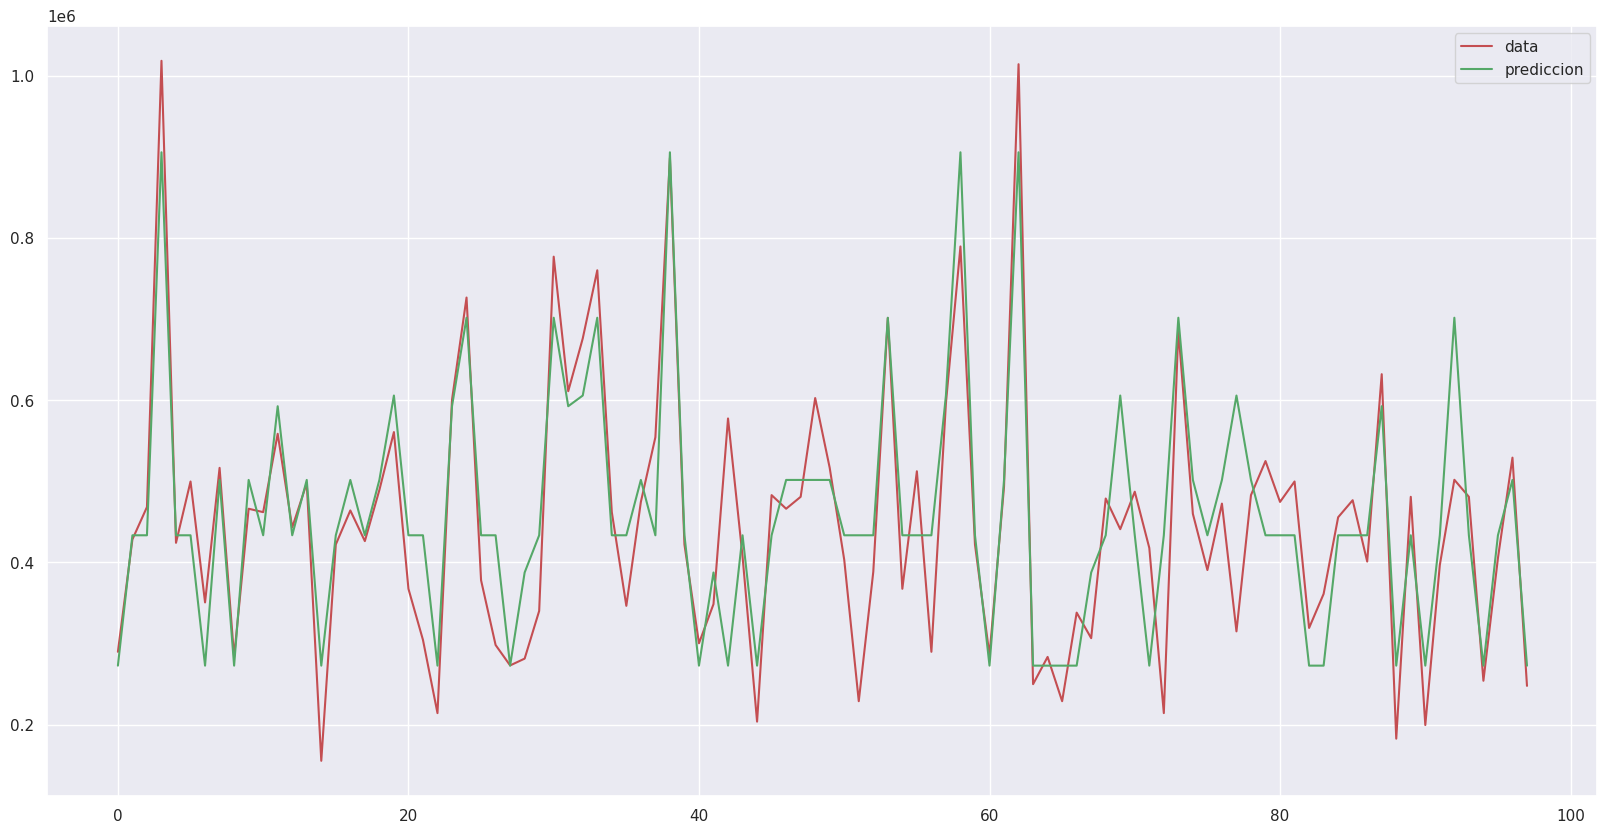

In [35]:
xx = np.stack([i for i in range(y_test.shape[0])])
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_prediccion, c='g', label='prediccion')
plt.axis('tight')
plt.legend()
plt.show()

**_Optimización de hiperparámetros_**

_Calcula la combinación de parámetros óptima (profundidad de árbol y criterio). Para ello realiza ejecuciones con cada uno de los valores del criterio para los valores de profundidad de árbol de 1 a 15._

In [36]:
x_df_housing = df_housing.drop("MEDV", axis=1)
y_df_housing = df_housing['MEDV']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "error_cuadratico_medio", "error_absoluto_medio"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_housing, y_df_housing, random_state=1, test_size=0.2)

for i in range(1, 16):
  modelo = DecisionTreeRegressor(max_depth=i)
  modelo.fit(x_entrenamiento, y_entrenamiento)

  y_prediccion = modelo.predict(x_test)

  df_opt.loc[len(df_opt)] = [i, mean_squared_error(y_test, y_prediccion), mean_absolute_error(y_test, y_prediccion)]


df_opt

,max_depth,error_cuadratico_medio,error_absoluto_medio
0,1.0,1.640670e+10,105006.178296
1,2.0,8.707562e+09,70118.896684
2,3.0,6.766083e+09,58691.457499
3,4.0,6.050132e+09,52717.171076
4,5.0,5.772657e+09,52032.823201
5,6.0,5.774172e+09,52509.287647
6,7.0,6.235465e+09,55192.508707
7,8.0,6.698192e+09,57167.970846
8,9.0,6.690783e+09,56547.685346
9,10.0,6.880682e+09,57053.819990


_Cada ejecución anterior se deberá hacer usando validación cruzada (por ejemplo n_splits = 5). Con ello obtendremos una medida de bondad del modelo (accuaracy_score o mean_absolute_error), como lo ejecutaremos 5 vedes, calcularemos la media de esas 5 ejecuciones._

In [37]:
x_df_housing = df_housing.drop("MEDV", axis=1)
y_df_housing = df_housing['MEDV']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "error_cuadratico_medio", "error_absoluto_medio"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_housing, y_df_housing, random_state=1, test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, 16):
  modelo = DecisionTreeRegressor(max_depth=i)
  puntuaciones_mae = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring=make_scorer(mean_absolute_error))
  puntuaciones_mse = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring=make_scorer(mean_squared_error))

  media_mae = np.mean(puntuaciones_mae)
  media_mse = np.mean(puntuaciones_mse)

  df_opt.loc[len(df_opt)] = [i, media_mse, media_mae]

df_opt

,max_depth,error_cuadratico_medio,error_absoluto_medio
0,1.0,1.851568e+10,104303.747923
1,2.0,1.087120e+10,75243.486458
2,3.0,5.746109e+09,57061.741145
3,4.0,5.429588e+09,55842.903030
4,5.0,5.930031e+09,57377.130405
5,6.0,6.708485e+09,60664.282265
6,7.0,6.639152e+09,61309.954758
7,8.0,7.266798e+09,63666.531258
8,9.0,7.357076e+09,66569.643917
9,10.0,8.271876e+09,66646.761461


_Finalmente los parámetros elegidos serán los que den mejor media de esas medidas anteriormente nombradas._

En este caso yo lo dejaría con los pasos que teníamos desde un principio (3), a partir de la profundidad 3 se puede obserbar que la existe apenas mejoría e incluso a veces aumenta. Esto nos puede indicar un sobre ajuste.

_Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostramos los resultados._

In [38]:
x_df_housing = df_housing.drop("MEDV", axis=1)
y_df_housing = df_housing['MEDV']

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_housing, y_df_housing, random_state=1, test_size=0.2)

modelo = DecisionTreeRegressor(max_depth=3)
modelo.fit(x_entrenamiento, y_entrenamiento)

y_prediccion = modelo.predict(x_test)

print("El error cuadrático medio:", mean_squared_error(y_test, y_prediccion))
print("El error absoluto medio:", mean_absolute_error(y_test, y_prediccion))


El error cuadrático medio: 6766082605.507382
El error absoluto medio: 58691.457498698874
